In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Burgers
problem = Burgers()

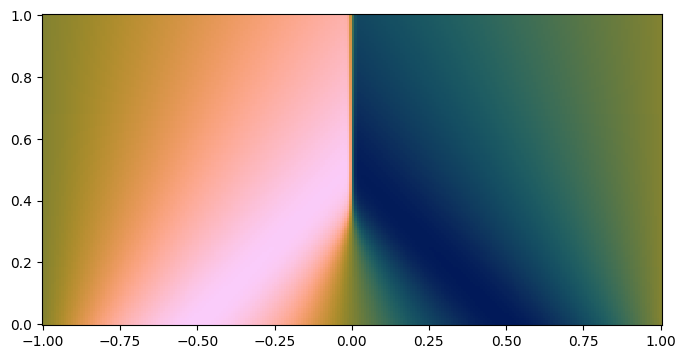

In [3]:
X, T, u_solution = problem.exact_solution(nx=256, nt=128)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

# Optimiser

In [4]:
class MonoMinLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.25,
        max_trials: int = 100,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array],
        collocation_points
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        # This vectorized function will be used for the initial loss calculation
        def vectorized_residual_fn(p):
            return jax.vmap(residual_fn, in_axes=(None, 0))(p, collocation_points)

        residuals = vectorized_residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        def single_row_jacobian_fn(p_flat, xt):
            # ... (Jacobian calculation code is correct) ...
            static = jax.tree_util.tree_map(lambda x: None if isinstance(x, jax.Array) else x, params)
            def residual_for_jac(p_flat_local):
                model = eqx.combine(unflatten(p_flat_local), static)
                return residual_fn(model, xt).sum()
            
            return jax.grad(residual_for_jac)(p_flat)
        
        J = jax.vmap(single_row_jacobian_fn, in_axes=(None, 0))(params_flat, collocation_points)
        Hessian_diag = jnp.sum(J**2, axis=0)
        D = jnp.diag(jnp.sqrt(Hessian_diag))
        J_hat = J @ jnp.linalg.inv(D)
        
        U_hat, S_hat, Vt_hat = jnp.linalg.svd(J_hat, full_matrices=False)
        g_hat = U_hat.T @ residuals

        # U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        # g = U.T @ residuals

        def evaluate_trial_step(loop_val):
            _, trial_lambda, previous_trial_loss, _, trial_count = loop_val
            # delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            delta_hat = -Vt_hat.T @ jnp.diag(S_hat / (S_hat**2 + trial_lambda)) @ g_hat
            delta = jnp.linalg.inv(D) @ delta_hat
            
            trial_params = eqx.apply_updates(params, unflatten(delta))
            
            # Use the vectorized_residual_fn to correctly compute residuals for all points
            trial_residuals = vectorized_residual_fn(trial_params)
            
            trial_loss = jnp.mean(trial_residuals**2)

            slope = -(jnp.log(trial_loss) - jnp.log(previous_trial_loss)) / (jnp.log(trial_lambda) - jnp.log(trial_lambda / self.increase_factor))

            accepted = (trial_loss < current_loss) & (slope < 0.1)

            # If rejected, increase lambda for the next trial
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda,
                lambda: trial_lambda * self.increase_factor
            )
            
            return accepted, new_lambda, trial_loss, delta, trial_count + 1

        def continue_search(loop_val):
            # Continue if step not accepted AND we haven't exceeded max trials
            accepted, _, trial_loss, _, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
        
        # Run the search loop
        initial_loop_val = (False, current_lambda, current_loss, jnp.zeros_like(params_flat), 0)
        
        accepted, final_lambda, new_loss, final_delta, count = jax.lax.while_loop(
            continue_search, evaluate_trial_step, initial_loop_val
        )

        updates = unflatten(final_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S_hat, #S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
            'trial_count': count
        }

        return current_loss, updates, new_state, metrics
    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    key, subkey = jax.random.split(key)

    def residual_fn_for_optimizer(p, x):
        rebuilt_model = eqx.combine(p, static_parts)
        # Corrected call without jnp.expand_dims
        return problem.physics_residual(rebuilt_model, x)

    loss, updates, new_opt_state, metrics = optimiser.update(
        params, opt_state, residual_fn_for_optimizer, collocation_points
    )
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key

@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, 
    candidate_points, 
    n_points_to_sample, 
    problem, # Pass the problem instance for its residual function
    k, # RAD hyperparameter
    c, # RAD hyperparameter
    key
):
    # 1. Calculate PDE residuals for all candidate points
    # Call the vmapped physics_residual function with the model and the batch of points
    vmapped_residual_fn = jax.vmap(problem.physics_residual, in_axes=(None, 0))
    residuals = vmapped_residual_fn(model, candidate_points)
        
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key, 
        a=candidate_points.shape[0], 
        shape=(n_points_to_sample,), 
        p=probs,
        replace=False # Sample without replacement
    )
    
    return candidate_points[indices]

In [5]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**14
n_candidate_points = 10 * n_collocation_points # Much larger pool
layer_sizes = [2, 20, 20, 20, 20, 1]
# -----------------------

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 50
rad_k = 1.5
rad_c = 1.0
# -----------------------------------

model_key, data_key, resample_key = jax.random.split(key, 3)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

# 1. Generate the candidate pool ONCE
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)

# 2. Get the initial set of collocation points
collocation_points = jax.random.choice(data_key, candidate_points, shape=(n_collocation_points,), replace=False)

start_time = time.monotonic()

epoch = 0

In [6]:
optimiser = MonoMinLM(
    init_lambda=1e5,
    decrease_factor=0.75,
    increase_factor=1.01,
    max_trials=100,
)
opt_state = optimiser.init(params)

In [7]:
for _ in range(500):
    epoch += 1
    
    # 3. Periodically resample points using RAD
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        resample_key, subkey = jax.random.split(resample_key)
        
        # We need the full model to calculate residuals for resampling
        current_model = eqx.combine(params, static) 
        
        collocation_points = resample_rad(
            current_model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )
        
    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Epoch 10, Loss: 1.829e+00, Time elapsed: 14.26 s
Epoch 20, Loss: 1.526e+00, Time elapsed: 21.17 s
Epoch 30, Loss: 4.341e-01, Time elapsed: 28.10 s
Epoch 40, Loss: 2.733e-01, Time elapsed: 34.29 s
Epoch 50, Loss: 9.127e-02, Time elapsed: 40.86 s
Epoch 60, Loss: 1.091e-01, Time elapsed: 50.51 s
Epoch 70, Loss: 3.459e-02, Time elapsed: 56.76 s
Epoch 80, Loss: 9.065e-03, Time elapsed: 63.16 s
Epoch 90, Loss: 2.831e-03, Time elapsed: 70.90 s
Epoch 100, Loss: 1.601e-03, Time elapsed: 77.82 s
Epoch 110, Loss: 6.946e-04, Time elapsed: 86.09 s
Epoch 120, Loss: 2.331e-04, Time elapsed: 93.00 s
Epoch 130, Loss: 1.035e-04, Time elapsed: 99.85 s
Epoch 140, Loss: 5.640e-05, Time elapsed: 107.67 s
Epoch 150, Loss: 3.243e-05, Time elapsed: 115.09 s
Epoch 160, Loss: 2.113e-05, Time elapsed: 122.87 s
Epoch 170, Loss: 1.064e-05, Time elapsed: 131.67 s
Epoch 180, Loss: 7.061e-06, Time elapsed: 139.17 s
Epoch 190, Loss: 4.569e-06, Time elapsed: 147.50 s
Epoch 200, Loss: 3.270e-06, Time elapsed: 155.36 s
Ep

KeyboardInterrupt: 

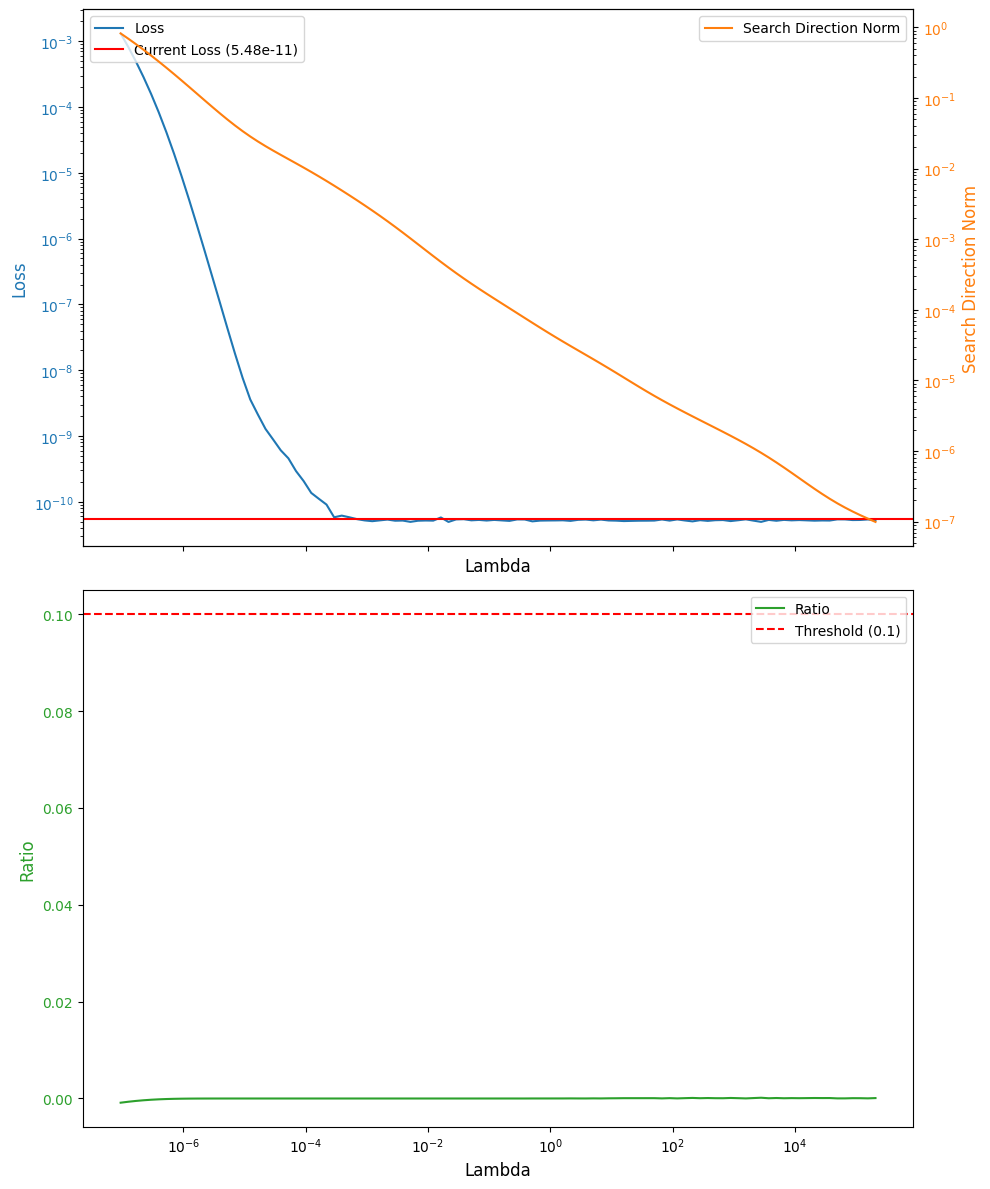

In [ ]:
params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

def single_point_residual_fn(model, xt):
    u = model(xt).squeeze()
    u_x, u_t = Burgers._u_grad_fn(model, xt)
    u_xx, _ = Burgers._u_xx_fn(model, xt)
    return u_t + u * u_x - (0.01 / jnp.pi) * u_xx

def full_residual_fn(p_flat):
    model_part = unflatten(p_flat)
    rebuilt_model = eqx.combine(model_part, static)
    residuals = jax.vmap(single_point_residual_fn, in_axes=(None, 0))(rebuilt_model, collocation_points)
    return residuals

def single_row_jacobian_fn(p_flat, xt):
    def residual_for_jac(p_flat_local):
        model_part = unflatten(p_flat_local)
        rebuilt_model = eqx.combine(model_part, static)
        return single_point_residual_fn(rebuilt_model, xt)

    return jax.grad(residual_for_jac)(p_flat)

J = jax.vmap(single_row_jacobian_fn, in_axes=(None, 0))(params_flat, collocation_points)

# Then you can proceed with SVD as J will be a 2D matrix
U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
Vt = Vt.T

residuals = full_residual_fn(params_flat)
g = U.T @ residuals


initial_residuals = full_residual_fn(params_flat)
initial_loss = jnp.mean(initial_residuals**2)

min_s = jnp.min(S)
max_s = jnp.max(S)
lambdas = jnp.logspace(jnp.log10(min_s / 10), jnp.log10(max_s * 10), 100)

losses = []
search_direction_norms = []
ratios = []

for trial_lambda in lambdas:
    # Calculate the search direction (delta)
    delta = -Vt @ jnp.diag(S / (S**2 + trial_lambda)) @ g

    # Calculate trial parameters and loss
    trial_params_flat = params_flat + delta
    trial_residuals = full_residual_fn(trial_params_flat)
    trial_loss = jnp.mean(trial_residuals**2)
    losses.append(trial_loss)

    # Calculate search direction norm
    search_direction_norm = jnp.linalg.norm(delta)
    search_direction_norms.append(search_direction_norm)

    predicted_reduction_numerator = (S**2 * g**2) / (S**2 + trial_lambda)
    predicted_reduction_denominator = trial_lambda * g**2 / ((S**2 + trial_lambda)**2)
    predicted_reduction = 0.5 * (jnp.sum(predicted_reduction_numerator) + jnp.sum(predicted_reduction_denominator))
    
    # Calculate actual reduction
    actual_reduction = initial_loss - trial_loss

    # Calculate the ratio
    # Add a small epsilon to the denominator to prevent division by zero
    ratio = actual_reduction / (predicted_reduction + 1e-12)
    ratios.append(ratio)


# --- 5. PLOTTING: Create and save the plot ---
results_df = pd.DataFrame({
    'lambda': lambdas,
    'loss': losses,
    'search_direction_norm': search_direction_norms,
    'ratio': ratios
})

fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(10, 12))

# Top subplot: Loss and Search Direction Norm
ax1.set_ylabel('Loss', color='tab:blue', fontsize=12)
ax1.plot(results_df['lambda'], results_df['loss'], color='tab:blue', label='Loss')
ax1.axhline(initial_loss, color='red', linestyle='-', label=f'Current Loss ({initial_loss:.2e})')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='upper left')
ax1.set_xlabel('Lambda', fontsize=12)

ax2 = ax1.twinx()
ax2.set_ylabel('Search Direction Norm', color='tab:orange', fontsize=12)
ax2.plot(results_df['lambda'], results_df['search_direction_norm'], color='tab:orange', label='Search Direction Norm')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_yscale('log')
ax2.legend(loc='upper right')

ax3.set_ylabel('Ratio', color='tab:green', fontsize=12)
ax3.plot(results_df['lambda'], results_df['ratio'], color='tab:green', label='Ratio')
ax3.axhline(0.1, color='red', linestyle='--', label='Threshold (0.1)')
ax3.set_xscale('log')
ax3.tick_params(axis='y', labelcolor='tab:green')
ax3.legend(loc='upper right')
ax3.set_xlabel('Lambda', fontsize=12)

# ax4 = ax3.twinx()
# ax4.set_ylabel('Frequency', fontsize=12)
# ax4.set_xscale('log')
# ax4.tick_params(axis='both')
# S2 = S**2
# min_val = S2.min()
# max_val = S2.max()
# num_bins = 50
# bins = np.logspace(np.log10(min_val), np.log10(max_val), num=num_bins)
# ax4.hist(S2, bins=bins, edgecolor='black', alpha=0.7)


fig.tight_layout()

Relative L2 Error: 5.916e-07


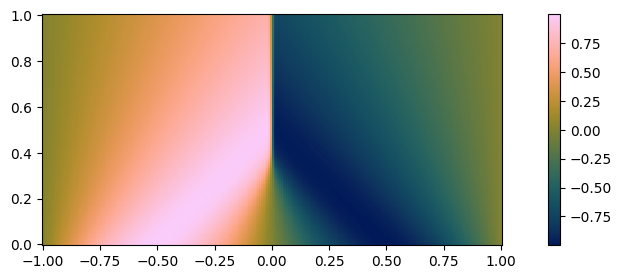

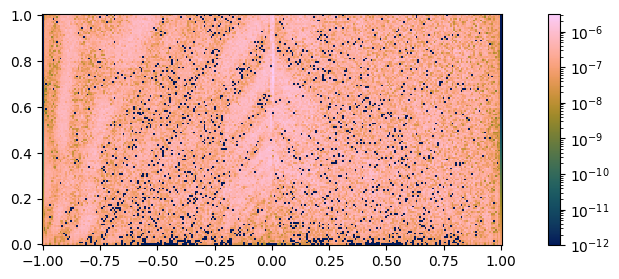

In [ ]:
model = eqx.combine(params, static)

u_pred = model.predict(X, T)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(nn_solution, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

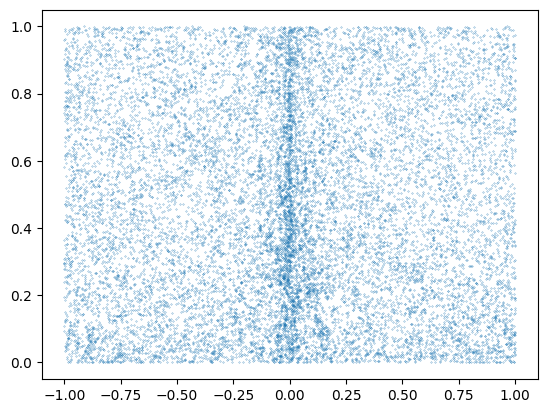

In [ ]:
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.05)
plt.show

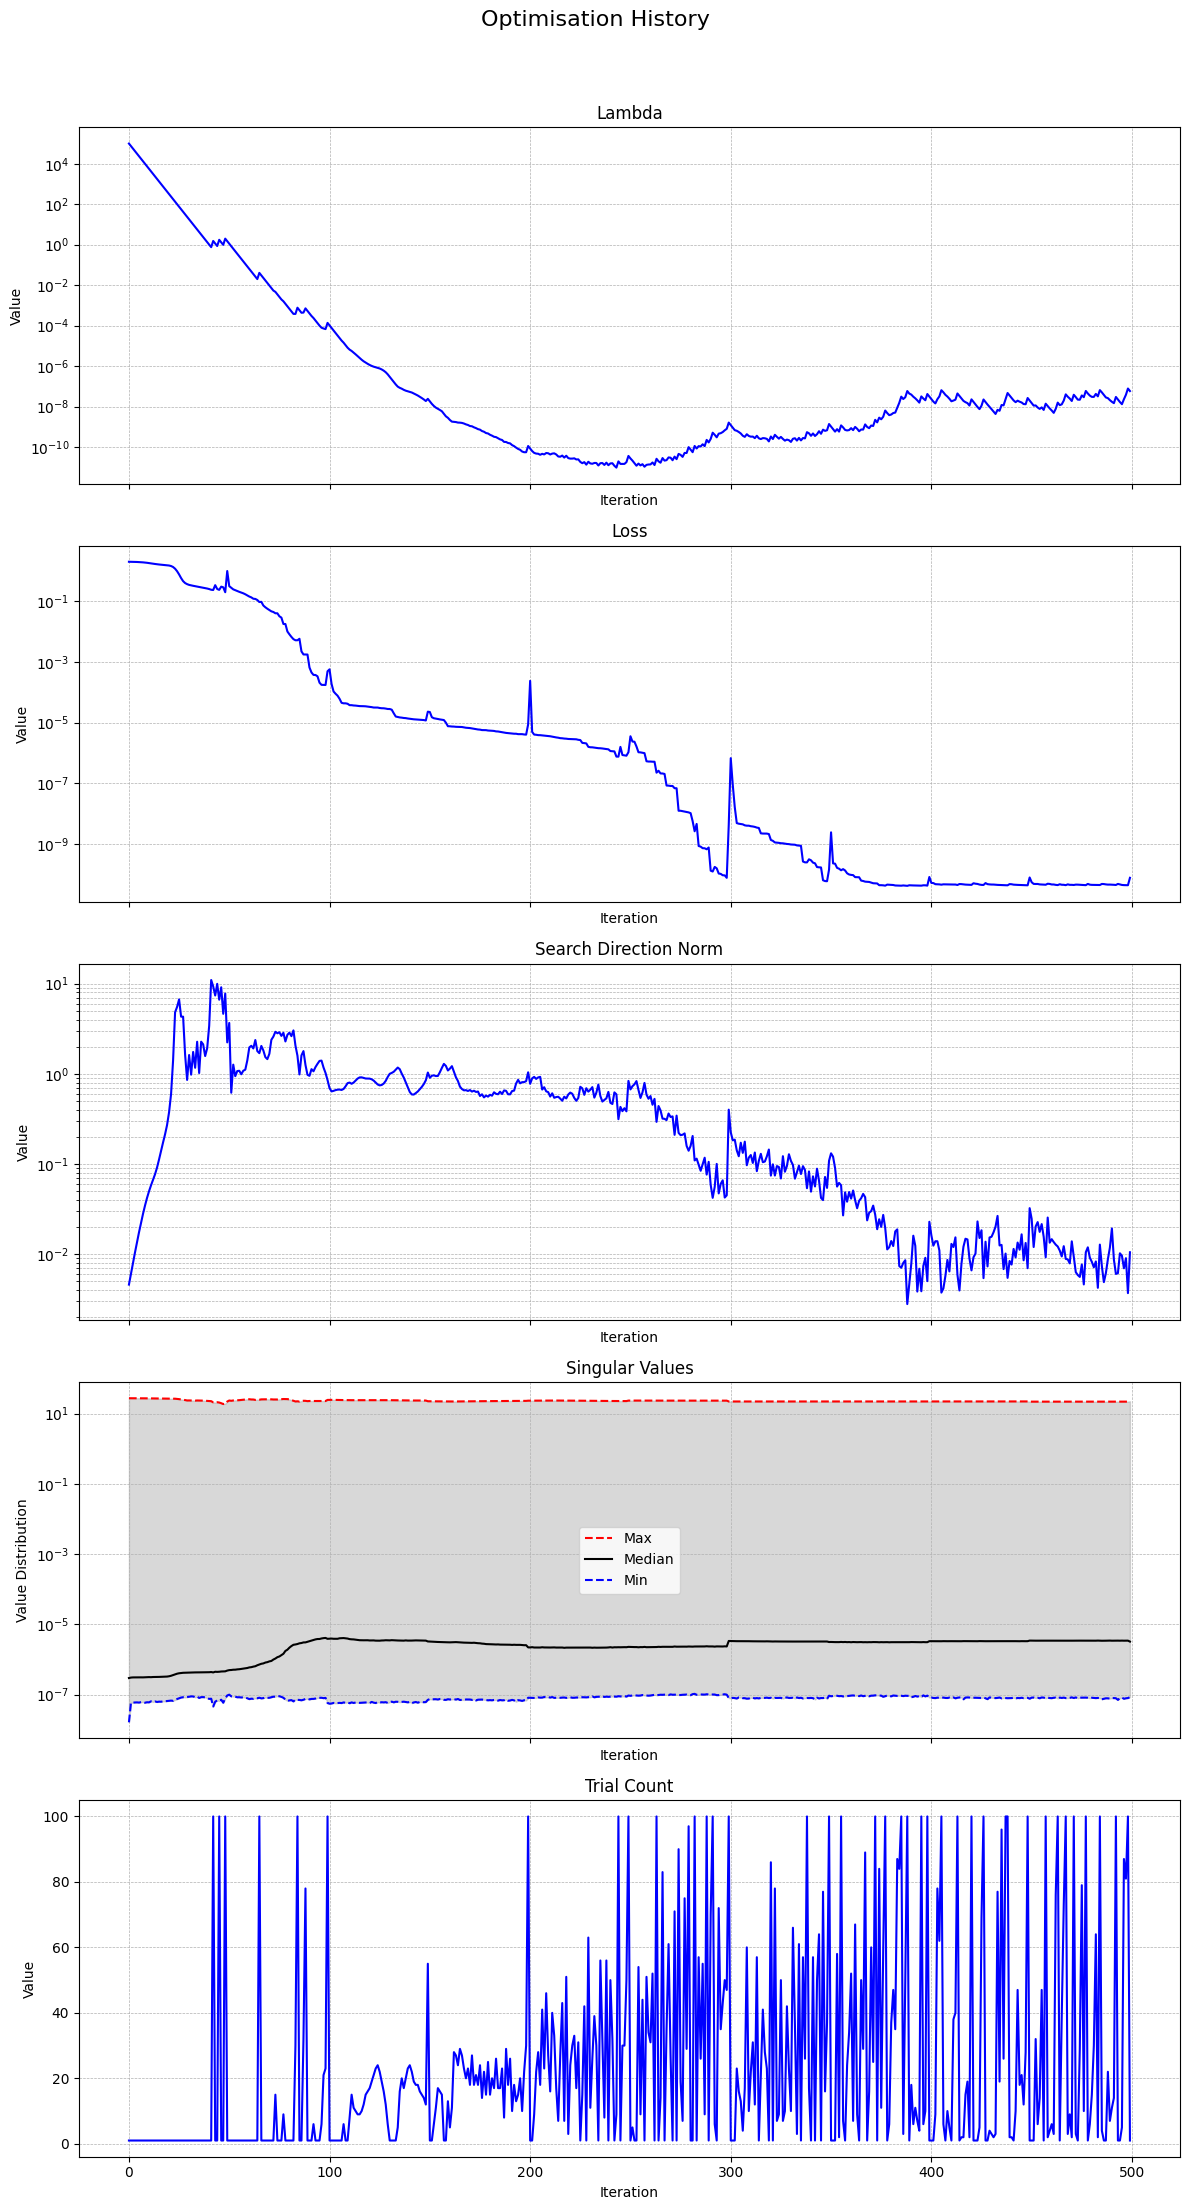

In [ ]:
history.plot()